# Álgebra Lineal Computacional
## TP Red Neuronal Lineal

In [2]:
import numpy as np
import time
from alc import *

## 1. Lectura de datos

In [3]:
X_train, Y_train, X_val, Y_val = cargar_dataset(carpeta='template-alumnos/dataset/cats_and_dogs')

In [4]:
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape} Y_val: {Y_val.shape}')

X_train: (1536, 2000), Y_train: (2, 2000)
X_val: (1536, 1000) Y_val: (2, 1000)


## 2. Ecuaciones normales

$X_{train} \in \mathbb{R}^{m \times n}$ con $m < n$, que es el caso **(b)** del algoritmo *Fully Connected Lineal con Cholesky en Rango Completo*.

Implementamos entonces ese caso del algoritmo.

In [ ]:
Xt = transpuesta(X_train)
XXt = multiplicar(X, Xt)
L = Cholesky(XXt)
W_cholesky = pinvEcuacionesNormales(X, L, Y)

# Guardamos resultado
np.save('W_cholesky.npy', W_cholesky)

In [4]:
W_cholesky = np.load("W_cholesky.npy")
W_cholesky.shape

(2, 1536)

## 3. Descomposición SVD

La implementación propia de descomposición SVD fue imposible de probar debido a los tiempos de ejecución (más de 5 horas); esto utilizando incluso las funciones de multiplicación de NumPy, etc.

In [ ]:
U, S, V = svd_reducida(X_train, atol=1e-1)

In [5]:
U, S, V = np.linalg.svd(X_train, full_matrices=False)

In [ ]:
W_svd = pinvSVD(U, S, V, Y_train)

# Guardamos resultado
np.save('W_svd.npy', W_svd)

In [17]:
W_svd = np.load("W_svd.npy")
W_svd.shape

(2, 1536)

## 4. Descomposición QR

Los métodos `pinvGramSchmidt` y `pinvHouseHolder` son idénticos porque el cálculo de $W$ a partir de $Q, R, Y$ no depende del tipo de factorización.

Sí cabe destacar que podrían optimizarse los métodos `inversa` y `multiplicar` haciendo uso de que $R$ es matriz triangular.

In [16]:
def pinvGramSchmidt(Q, R, Y):
    """
    Recibe Q, R factores de X.T y la matriz Y.
    Calcula X⁺ = Q (R.T)⁻¹
    Calcula W = Y X⁺
    """
    R_T = transpuesta(R)
    R_inv = inversa(R_T)
    W = multiplicar(Y, multiplicar(Q, R_inv))
    return W

def pinvHouseHolder(Q, R, Y):
    """
    Recibe Q, R factores de X.T y la matriz Y.
    Calcula X⁺ = Q (R.T)⁻¹
    Calcula W = Y X⁺
    """
    R_T = transpuesta(R)
    R_inv = inversa(R_T)
    W = multiplicar(Y, multiplicar(Q, R_inv))
    return W

#### Gram Schmidt

In [ ]:
# Factorizamos
Q_gs, R_gs = QR_con_GS(transpuesta(X_train))

# Guardamos matrices
np.save('Q_gs.npy', Q_gs)
np.save('R_gs.npy', R_gs)

In [5]:
Q_gs = np.load('Q_gs.npy')
R_gs = np.load('R_gs.npy')

In [26]:
print(f'Q_gs: {Q_gs.shape}, R_gs: {R_gs.shape}')

Q_gs: (2000, 1536), R_gs: (2000, 1536)


Recortamos $R_{gs}$ para reducir su tamaño a una cuadrada (**las filas inferiores de la matriz R son nulas** como resultado de la factorización).

In [13]:
# Las filas inferiores son nulas
assert np.allclose(R_gs[1536:, :], 0, atol=1e-12)

In [6]:
# Recortamos la matriz R
R_gs = R_gs[:1536, :]
print(f'Q_gs: {Q_gs.shape}, R_gs: {R_gs.shape}')

Q_gs: (2000, 1536), R_gs: (1536, 1536)


In [ ]:
W_gs = pinvHouseHolder(Q_gs, R_gs, Y_train)
np.save('W_gs.npy', Q_gs)

In [7]:
W_gs = np.load('W_gs.npy')
W_gs.shape

(2, 1536)

#### Householder

In [ ]:
# Factorizamos
Q_hh, R_hh = QR_con_HH(transpuesta(X_train))

# Guardamos matrices
np.save('Q_hh.npy', Q_hh)
np.save('R_hh.npy', R_hh)

In [20]:
Q_hh = np.load('Q_hh.npy')
R_hh = np.load('R_hh.npy')

In [21]:
print(f'Q_hh: {Q_hh.shape}, R_hh: {R_hh.shape}')

Q_hh: (2000, 2000), R_hh: (2000, 1536)


Recortamos $Q_{gs}$ y $R_{gs}$ para reducir los tamaños (las filas inferiores de la matriz R son nulas como resultado de la factorización).

In [13]:
# Las filas inferiores son nulas
assert np.allclose(R_gs[1536:, :], 0, atol=1e-12)

In [23]:
# Recortamos las matrices
Q_hh = Q_hh[:, :1536]
R_hh = R_hh[:1536, :]
print(f'Q_hh: {Q_hh.shape}, R_hh: {R_hh.shape}')

Q_hh: (2000, 1536), R_hh: (1536, 1536)


In [ ]:
W_hh = pinvHouseHolder(Q_hh, R_hh, Y_train)
np.save('W_hh.npy', W_hh)

In [8]:
W_hh = np.load('W_hh.npy')
W_hh.shape

(2, 1536)

## 5. Pseudo-inversa de Moore-Penrose

Separamos las condiciones por claridad, pero no se aprovecha el *short-circuit* de los operadores `and`. Podría definirse de otra manera e implementar *short-circuit* para mejor desempeño.

In [3]:
def esPseudoInverda(X, pX, atol=1e-8):
    """
    Recibe matrices X y pX.
    Devuelve True si pX verifica las 4 condiciones de Moore-Penrose, False en otro caso.
    """
    condicion1 = matricesIguales(multiplicar(multiplicar(X, pX), X), X, atol=atol)
    condicion2 = matricesIguales(multiplicar(multiplicar(pX, X), pX), pX, atol=atol)
    condicion3 = simetrica(multiplicar(X, pX), atol=atol)
    condicion4 = simetrica(multiplicar(pX, X), atol=atol)

    return (condicion1 and condicion2 and condicion3 and condicion4)

## 6. Evaluación y Benchmarking

In [18]:
def matrizDeConfusion(W, Xv, Yv):
    """
    W matriz de pesos, vectores Xv de validación y target Yv de validación.
    Devuelve M matriz de confusión, la exactitud y precisiones de las clases 0 y 1.
    """    
    y_pred = W @ Xv

    M = np.zeros((2,2), dtype=int)
    _, p = Xv.shape
    _, n = Yv.shape
    
    for j in range(p): # Por cada muestra
        # Valor esperado
        if Yv[0, j] == 1:
            expected = 0
        else:
            expected = 1

        # Valor predecido
        if y_pred[0, j] > y_pred[1, j]:
            prediction = 0
        else:
            prediction = 1

        # Actualizar matriz de confusión
        M[expected, prediction] += 1

    exactitud = (M[0,0] + M[1,1]) / n
    precision_0 = M[0,0] / (M[0,0] + M[1,0])
    precision_1 = M[1,1] / (M[1,1] + M[0,1])

    return M, exactitud, precision_0, precision_1

### Comparación entre métodos

#### Matrices de confusión

In [13]:
matrizDeConfusion(W_cholesky, X_val, Y_val)

(array([[334, 166],
        [150, 350]]),
 0.684,
 0.6900826446280992,
 0.6782945736434108)

In [19]:
matrizDeConfusion(W_svd, X_val, Y_val)

(array([[334, 166],
        [150, 350]]),
 0.684,
 0.6900826446280992,
 0.6782945736434108)

In [14]:
matrizDeConfusion(W_gs, X_val, Y_val)

(array([[334, 166],
        [150, 350]]),
 0.684,
 0.6900826446280992,
 0.6782945736434108)

In [15]:
matrizDeConfusion(W_hh, X_val, Y_val)

(array([[334, 166],
        [150, 350]]),
 0.684,
 0.6900826446280992,
 0.6782945736434108)

#### Tabla de resultados

Los resultados son idénticos para las cuatro metodologías porque la matriz de pesos $W$ calculada es idéntica (salvo cierta tolerancia numérica).

| Algoritmo | Exactitud | Precisión de la clase 0 | Precisión de la clase 1 |
|:---|:---:|:---:|:---:|
| Cholesky | 68.4% | 69.0% | 67.8% |
| SVD | 68.4% | 69.0% | 67.8% |
| Gram-Schmidt QR | 68.4% | 69.0% | 67.8% |
| Householder QR | 68.4% | 69.0% | 67.8% |

#### Gráfico

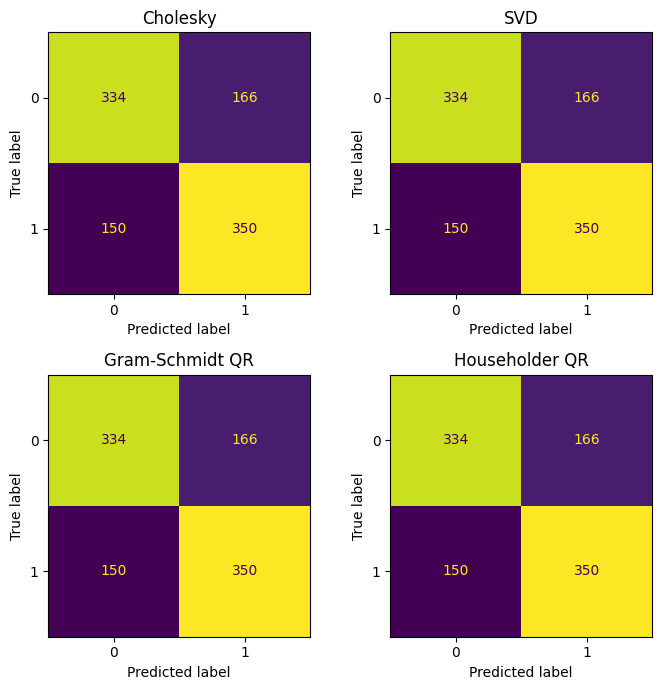

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(7, 7))

M_cholesky, _, _, _ = matrizDeConfusion(W_cholesky, X_val, Y_val)
M_svd, _, _, _ = matrizDeConfusion(W_svd, X_val, Y_val)
M_gs, _, _, _ = matrizDeConfusion(W_gs, X_val, Y_val)
M_hh, _, _, _ = matrizDeConfusion(W_hh, X_val, Y_val)

matrices = [M_cholesky, M_svd, M_gs, M_hh]
titulos = ['Cholesky', 'SVD', 'Gram-Schmidt QR', 'Householder QR']

for ax, M, titulo in zip(axes.flat, matrices, titulos):
    disp = ConfusionMatrixDisplay(M)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(titulo)

plt.tight_layout()
plt.show()

## 7. Síntesis final

Las cuatro metodologías resultan en la **misma performance** (medida como la exactitud de predicción) porque en los cuatro casos **la matriz de pesos $W$ que resulta del entrenamiento es idéntica** (salvo cierta tolerancia numérica).

### Consideraciones de desempeño/complejidad computacional

En general, tuvimos dificultades para ejecutar los métodos utilizando nuestras implementaciones en *Python puro* sin utilizar funciones vectorizadas de NumPy.

En algunos casos, fue prácticamente imposible (**horas de ejecución sin resultados**).

Esta situación también nos llevó a optimizar algoritmos que habíamos implementado -pareciera- de manera *naif* (i.e. poco eficiente).

#### Metodología Cholesky

Respecto al algoritmo que usa factorización de Cholesky, implementamos solo el caso **(b)** que sería el que corresponde a nuestro escenario.

El tiempo de ejecución fue del orden de 30'.

#### Metodología SVD

Para la metodología SVD nos vimos forzados a usar la implementación de NumPy `np.linalg.svd()`.

#### Metodología QR

Respecto a la optimización de los algoritmos de factorización QR, reemplazamos la multiplicación de matrices enteras por bloques de tamaño reducido; aprovechando la lógica de filas/columnas nulas o invariantes.

Logramos tiempos de ejecución del orden de 40' para Gram-Schmidt y 60' para Householder.

Medimos la mejora con un benchmark de 30 muestras de matrices 30 x 30; para el la factorización Housholder obtuvimos tiempos entre 10 a 100 veces mejores:

| Algoritmo | Tiempo promedio | Mejor tiempo |
|:---|:---:|:---:|
| NumPy LAPACK | 0.00017 seg | 0.00013 seg |
| Gram-Schmidt naif | 0.04047 seg | 0.03340 seg |
| Gram-Schmidt optimizado | 0.01434 seg | 0.01184 seg |
| Householder naif | 1.02379 seg | 0.85465 seg |
| Householder optimizado | 0.03032 seg | 0.02463 seg |